In [2]:
library(imager)
library(data.table)
library(dtplyr)
library(dplyr)
library(readr)
library(ggplot2)
library(plotly)
library(mxnet)

Loading required package: plyr
Loading required package: magrittr

Attaching package: ‘imager’

The following object is masked from ‘package:magrittr’:

    add

The following object is masked from ‘package:plyr’:

    liply

The following objects are masked from ‘package:stats’:

    convolve, spectrum

The following object is masked from ‘package:graphics’:

    frame

The following object is masked from ‘package:base’:

    save.image


Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘plotly’

The following object is masked from ‘package:ggplot2’:

    last_plot

The following object is masked fro

In [3]:
data_path_base <- "~/data/dogcats"

train_path <- file.path(data_path_base,"train")
test_path <- file.path(data_path_base,"test")

#### Create two lists, one for cats and other for dogs. This function uses a 
####  pattern maching approach with the parameter "pattern" which has as input
####  a regular expression.
cat_files<- list.files(path = train_path, pattern = "cat.+")
dog_files<- list.files(path = train_path, pattern = "dog.+")

### Randomize image order
set.seed(123)
cat_files<- sample(cat_files)
dog_files<- sample(dog_files)

### List test files and order them by name
test_files<- list.files(path = test_path, pattern = ".+\\.jpg")
test_num<- as.numeric(gsub(pattern="(\\d+)(.+)", replacement = "\\1", x = test_files))
test_position<- order(test_num)
test_files<- test_files[test_position]

head(cat_files)
head(dog_files)
head(test_files)

[1] "cat.1986.jpg"  "cat.7619.jpg"  "cat.3350.jpg"  "cat.8683.jpg" 
[5] "cat.9328.jpg"  "cat.10512.jpg"

[1] "dog.339.jpg"   "dog.299.jpg"   "dog.3155.jpg"  "dog.9661.jpg" 
[5] "dog.10564.jpg" "dog.1137.jpg"

[1] "1.jpg" "2.jpg" "3.jpg" "4.jpg" "5.jpg" "6.jpg"

In [4]:
### Load images and and convert to array
train_prep<- function(start,end, size){

  count<- 2*length(start:end)
  # Initialize array with NA ([Size x Size x 3 channels (RGB)] x number of img) 
  data_array<- array(NA, dim = c(size, size, 3, count)) 
  
  for (i in start:end) {
    # Load jpeg into imageR
    cat <- load.image(file.path(train_path, cat_files[i]))
    # Resize image to a 80x80 with 3 channels image
    cat<- resize(cat,size_x = size, size_y = size, size_c = 3, interpolation_type = 2)
    # Transform the image into a vector/array
    cat_array<-t(round(array(cat),4))
      
    dog <- load.image(file.path(train_path, dog_files[i]))
    dog<- resize(dog,size_x = size, size_y = size, size_c = 3, interpolation_type = 2)
    dog_array<-t(round(array(dog),4))
    
    # Add images to the result
    data_array[, , , 2*(i-start+1)-1]<- cat_array
    data_array[, , , 2*(i-start+1)]<- dog_array
  }
  return(data_array)
}

size <- 80 # In this case we want images of 80x80 pixels.

# Get the first 160 training images
train_array<- train_prep(start=1, end=160, size=size)
# Generate labels. As we are getting one cat and one dog, we can just repeat the
#  labels 0 (cat) and 1 (dog) 160 times. It will generate a vector of 160*2 
#  positions.
train_labels<- rep(c(0,1), times=160)

# Generate evaluation set.
eval_array<- train_prep(start=10001, end=10032, size=size)
eval_labels<- rep(c(0,1), times=32)

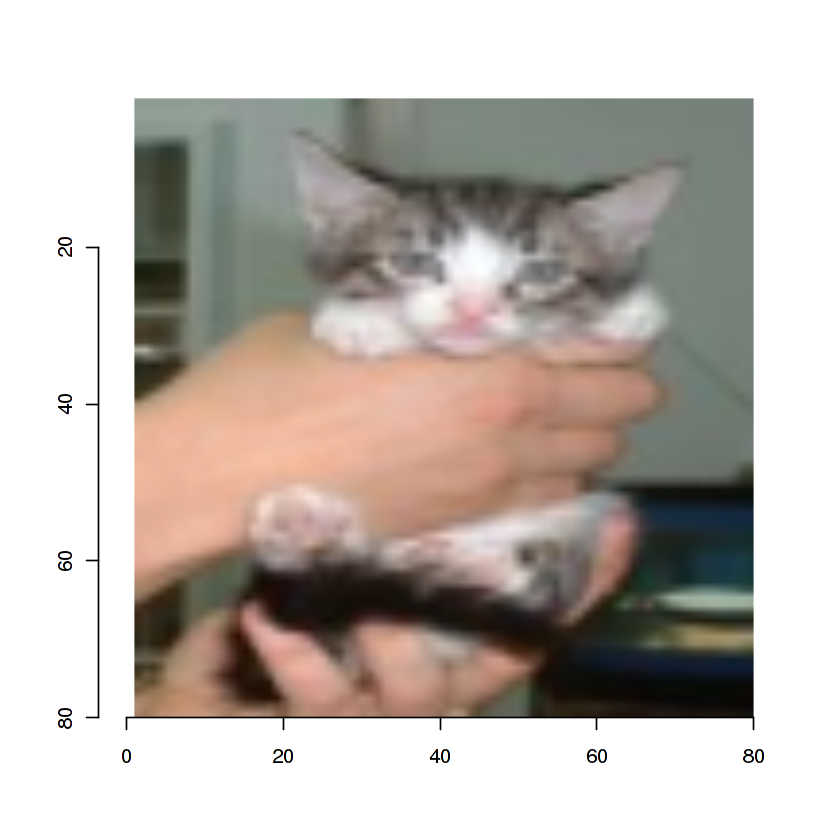

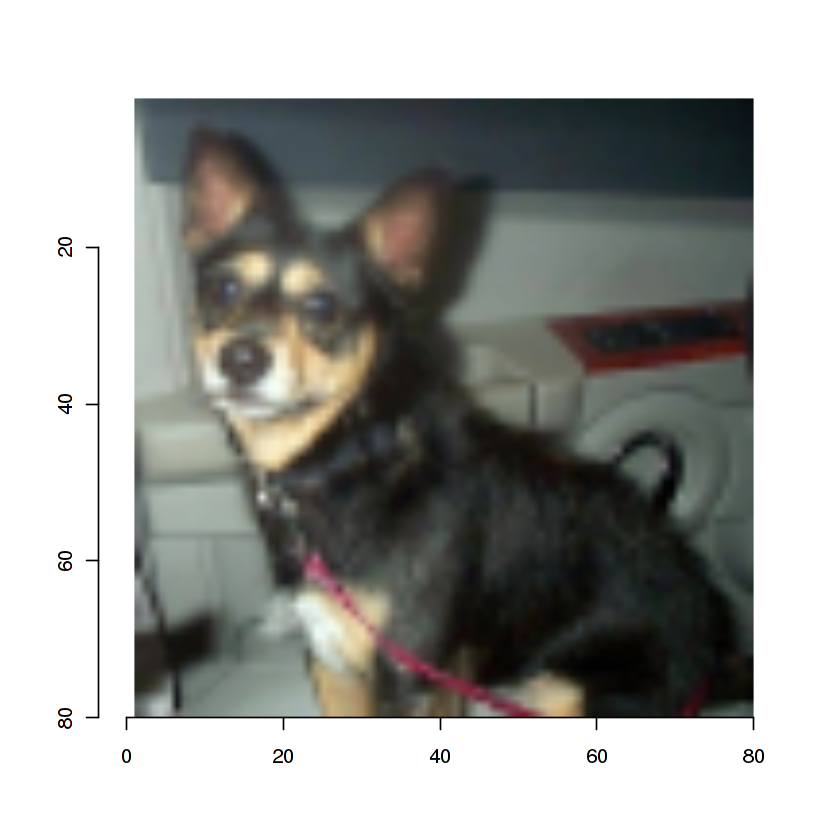

In [5]:
# Get first cat cat
img_test <- train_array[, , , 1]
dim(img_test) <- c(size, size, 1, 3)
img_test <- as.cimg(img_test)
plot(img_test)

# Get the first dog
img_test <- train_array[, , , 2]
dim(img_test) <- c(size, size, 1, 3)
img_test <- as.cimg(img_test)
plot(img_test)

In [6]:
# input
data <- mx.symbol.Variable('data')

conv1A <- mx.symbol.Convolution(data=data, kernel=c(3,3), num_filter=32, stride=c(1,1), pad=c(1,1))
act1A <- mx.symbol.Activation(data=conv1A, act_type="relu")
conv1B <- mx.symbol.Convolution(data=act1A, kernel=c(3,3), num_filter=32, stride=c(1,1), pad=c(1,1))
act1B <- mx.symbol.Activation(data=conv1B, act_type="relu")
pool1<- mx.symbol.Pooling(data=act1B, pool_type="max", kernel=c(2,2), stride=c(2,2), pad=c(0,0))

conv2A <- mx.symbol.Convolution(data=pool1, kernel=c(3,3), num_filter=64, stride=c(1,1), pad=c(1,1))
act2A <- mx.symbol.Activation(data=conv2A, act_type="relu")
conv2B <- mx.symbol.Convolution(data=act2A, kernel=c(3,3), num_filter=64, stride=c(1,1), pad=c(1,1))
act2B <- mx.symbol.Activation(data=conv2B, act_type="relu")
pool2<- mx.symbol.Pooling(data=act2B, pool_type="max", kernel=c(2,2), stride=c(2,2), pad=c(0,0))

conv3A <- mx.symbol.Convolution(data=pool2, kernel=c(3,3), num_filter=128, stride=c(1,1), pad=c(1,1))
act3A <- mx.symbol.Activation(data=conv3A, act_type="relu")
conv3B <- mx.symbol.Convolution(data=act3A, kernel=c(3,3), num_filter=128, stride=c(1,1), pad=c(1,1))
act3B <- mx.symbol.Activation(data=conv3B, act_type="relu")
pool3<- mx.symbol.Pooling(data=act3B, pool_type="max", kernel=c(2,2), stride=c(2,2), pad=c(0,0))

conv4A <- mx.symbol.Convolution(data=pool3, kernel=c(3,3), num_filter=128, stride=c(1,1), pad=c(1,1))
act4A <- mx.symbol.Activation(data=conv4A, act_type="relu")
conv4B <- mx.symbol.Convolution(data=act4A, kernel=c(3,3), num_filter=128, stride=c(1,1), pad=c(1,1))
act4B <- mx.symbol.Activation(data=conv4B, act_type="relu")
pool4<- mx.symbol.Pooling(data=act4B, pool_type="max", kernel=c(2,2), stride=c(2,2), pad=c(0,0))

# flatten
flatten <- mx.symbol.Flatten(data=pool4)

fc1 <- mx.symbol.FullyConnected(data=flatten, num_hidden=512)
act_fc1 <- mx.symbol.Activation(data=fc1, act_type="relu")
drop1 <- mx.symbol.Dropout(data=act_fc1, p=0.5)

# loss
fc_final <- mx.symbol.FullyConnected(data=drop1, num_hidden=2)
convnet <- mx.symbol.SoftmaxOutput(data=fc_final)

### plot the model structure
graph.viz(convnet)

# input
data <- mx.symbol.Variable('data')

conv1A <- mx.symbol.Convolution(data=data, kernel=c(3,3), num_filter=128, stride=c(1,1), pad=c(1,1))
act1A <- mx.symbol.Activation(data=conv1A, act_type="relu")
conv1B <- mx.symbol.Convolution(data=act1A, kernel=c(3,3), num_filter=128, stride=c(1,1), pad=c(1,1))
act1B <- mx.symbol.Activation(data=conv1B, act_type="relu")
pool1<- mx.symbol.Pooling(data=act1B, pool_type="max", kernel=c(2,2), stride=c(2,2), pad=c(0,0))

conv2A <- mx.symbol.Convolution(data=pool1, kernel=c(3,3), num_filter=64, stride=c(1,1), pad=c(1,1))
act2A <- mx.symbol.Activation(data=conv2A, act_type="relu")
conv2B <- mx.symbol.Convolution(data=act2A, kernel=c(3,3), num_filter=64, stride=c(1,1), pad=c(1,1))
act2B <- mx.symbol.Activation(data=conv2B, act_type="relu")
pool2<- mx.symbol.Pooling(data=act2B, pool_type="max", kernel=c(2,2), stride=c(2,2), pad=c(0,0))

# flatten
flatten <- mx.symbol.Flatten(data=pool2)

fc1 <- mx.symbol.FullyConnected(data=flatten, num_hidden=512)
act_fc1 <- mx.symbol.Activation(data=fc1, act_type="relu")
drop1 <- mx.symbol.Dropout(data=act_fc1, p=0.05)

# loss
fc_final <- mx.symbol.FullyConnected(data=drop1, num_hidden=2)
convnet <- mx.symbol.SoftmaxOutput(data=fc_final)

### plot the model structure
graph.viz(convnet)

HTML widgets cannot be represented in plain text (need html)

HTML widgets cannot be represented in plain text (need html)

In [10]:
devices <- mx.cpu()

### combine symbols and create executor for inspection of learned features
combined<- mx.symbol.Group(act1A, convnet)
executor <- mx.simple.bind(symbol=combined, data=dim(train_array), ctx=devices)

In [11]:
devices

$device
[1] "cpu"

$device_id
[1] 0

$device_typeid
[1] 1

attr(,"class")
[1] "MXContext"

In [13]:
mx.set.seed(123)
model_mxnet <- mx.model.FeedForward.create(convnet,
                                               X=train_array, 
                                               y=train_labels,
                                               eval.data = list(data=eval_array, label=eval_labels),
                                               array.batch.size = 10, 
                                               ctx=devices, 
                                               num.round=50,
                                               learning.rate=0.05,
                                               wd=0.001,
                                               momentum=0.1,
                                               clip_gradient=1,
                                               eval.metric=mx.metric.accuracy, 
                                               initializer=mx.init.Xavier(rnd_type = "gaussian", factor_type = "avg", magnitude = 3),
                                               epoch.end.callback = mx.callback.log.train.metric(1))

Start training with 1 devices
[1] Train-accuracy=0.509677419354839
[1] Validation-accuracy=0.5
[2] Train-accuracy=0.5
[2] Validation-accuracy=0.5
[3] Train-accuracy=0.484375
[3] Validation-accuracy=0.5
[4] Train-accuracy=0.5
[4] Validation-accuracy=0.5
[5] Train-accuracy=0.50625
[5] Validation-accuracy=0.5
[6] Train-accuracy=0.50625
[6] Validation-accuracy=0.5
[7] Train-accuracy=0.509375
[7] Validation-accuracy=0.5
[8] Train-accuracy=0.5
[8] Validation-accuracy=0.5
[9] Train-accuracy=0.509375
[9] Validation-accuracy=0.5
[10] Train-accuracy=0.503125
[10] Validation-accuracy=0.5
[11] Train-accuracy=0.509375
[11] Validation-accuracy=0.5
[12] Train-accuracy=0.509375
[12] Validation-accuracy=0.5
[13] Train-accuracy=0.509375
[13] Validation-accuracy=0.5
[14] Train-accuracy=0.521875
[14] Validation-accuracy=0.514285714285714
[15] Train-accuracy=0.5375
[15] Validation-accuracy=0.514285714285714
[16] Train-accuracy=0.496875
[16] Validation-accuracy=0.5
[17] Train-accuracy=0.515625
[17] Validati

In [ ]:
mx.exec.update.arg.arrays(exec = executor, arg.arrays = model_mxnet$arg.params, match.name=TRUE)
mx.exec.update.arg.arrays(executor, list(data=mx.nd.array(train_array)), match.name=TRUE)
mx.exec.forward(executor, is.train=FALSE)

par(mfrow=c(4,4), mar=c(0.1,0.1,0.1,0.1))
for (i in 1:16) {
  img_array <- as.array(executor$outputs$activation0_output)[,,i,1]
  img<-as.cimg(img_array)
  plot(img)
}

pred_prob<- t(predict(model_mxnet, eval_array))
submit <- data.frame(id=1:64, label=pred_prob[, 2])
head(submit)